# Barrents sea - Data Scientist Notebook for CTD data processing

## Introduction
This Notebook provides guidance and support for data processing of **Conductivity Temperature Depth (CTD)** measurements (instruments onboard of research vessels) and acquired from 1991 to 2020.

The data access relies on queries to remote **OPeNDAP servers** hosting the CTD data, and the data processing makes use of the Geostatistical Library (**RIntaros / RGeostats**) for the modelisation of geostatistical relationships between variables, and to interpolate gridded data maps out of irregular CTD point measurements. Estimated maps can be generated for a given **2D area**, a fixed **depth** and a selected **time interval**.

The CTD data access point is pre-configured for the OPeNDAP Hyrax server operated by the **Institute of Marine Research, Norwegian Marine Data Centre**, Norway
http://opendap1.nodc.no/opendap/physics/point/yearly/contents.html

Note: for the NMDC server, the **.nc4** extension from the data access URLs is not supported.

The selection for CTD campaigns at sea is supported via the **year** parameter in the *fetch_data(url, year)* function in *helpers.py*, and consequently all the *fetch_data(url, year)* function calls within the Notebook. 

Citation: refer to the EC INTAROS project: https://cordis.europa.eu/project/id/727890.

More information on the RIntaros and RGeostats packages is available on: http://cg.ensmp.fr/rgeostats.

# Extraction of NetCDF Data

## Exploratory Data Analysis

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import xarray as xr
import os
from pyproj import Transformer
from datetime import datetime, timedelta

from helpers import *

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, WheelZoomTool, BoxZoomTool, ResetTool, PanTool
from bokeh.io import output_notebook
from bokeh.tile_providers import OSM, get_provider

from lxml import html
import requests

### Set-up

#### Server URL
We select the OPeNDAP NMDC server where CTD datasets are hosted for our Arctic region of interest: http://opendap1.nodc.no/opendap/physics/point/yearly/.

The first thing is to get an understanding of the server content (exploring the URL within a browser), in particular the years of the campaings at sea, the naming convention for the "platforms" (i.e. the research vessels), the variables and attributes that are available.

In [2]:
# URL of Norwegian Marine Data Centre (NMDC) data server
nmdc_url = 'http://opendap1.nodc.no/opendap/physics/point/yearly/' 

# URL of Terradue Cloud Platform Hyrax server
# Ellip user account and VPN setup required
t2_hyrax_url = 'https://opendap.terradue.com/hyrax/data/subset_2003/'

urls = {}
urls['nmdc'] = [nmdc_url, '']
urls['t2_hyrax'] = [t2_hyrax_url, '.nc4']

#========================================================
# Define below the URL to use (either 'nmdc' or 't2_hyrax'):
url_info = urls['nmdc']
#========================================================

print('Server URL and URL suffix:', url_info)

Server URL and URL suffix: ['http://opendap1.nodc.no/opendap/physics/point/yearly/', '']


#### Define Time of Interest
For the purpose of this analysis, we explore data within the range of a full year of interest. Time range filters will operate within this given year. 
Multi-year analysis would require some adaptation to the code. 

In [3]:
# Define year of interest
year = 2003 

Time start and time end, bounding box and the depth are also important user inputs (as much as the year) as they are used for filtering the data and defining the target estimated map. They will be customized later on (next cells).

### Retrieval of DDS info
The OPeNDAP's Dataset Descriptor Structure (DDS) delivers lightweight information, useful for the application developer to visually analyse and understand the dataset at hand (geographic and temporal extends covered, and eventual data gaps).  

Accessing the data using the DDS info we retrieve the dimensions of the data for: **TIME**, **LATITUDE**, **LONGITUDE**, **DEPTH**.

In [4]:
# Get dds info, and assign max dimensions to TIME and DEPTH
pc_dim_dict = {}
time_stop_dict = {}
depth_stop_dict = {}

# get all content of the server_url, and then filter it with year and available platforms
page = requests.get(url_info[0])
webpage = html.fromstring(page.content)

# urls_filtered = [p for p in webpage.xpath('//a/@href') if p.endswith(str(year)+'.nc.dds')]
urls_filtered = [p for p in webpage.xpath('//a/@href') if p.endswith(f'{year}.nc{url_info[1]}.dds')]

for u in urls_filtered:
    
    dds = f'{url_info[0]}/{u}'; print(dds)
    
    # Find platform code
    if len(url_info[1]) == 0: pc = dds.split('_')[0][-2:] # nmdc case
    else: pc = dds.split('_')[1][-2:] # t2_hyrax case
    
    pc_dim_dict[pc] = retrieveDDSinfo(dds)
    
    time_stop_dict[pc] = pc_dim_dict[pc]['TIME']
    depth_stop_dict[pc] = pc_dim_dict[pc]['DEPTH']

assert depth_stop_dict.keys() == time_stop_dict.keys(), 'TIME and DEPTH Keys error. Please check.'

# Extract all platform_codes
platform_codes = [kd for kd in depth_stop_dict.keys()]
print(f'Available platforms in given year {year}: {platform_codes}')

# Print dimensions
print('TIME:', time_stop_dict)
print('DEPTH:', depth_stop_dict)

http://opendap1.nodc.no/opendap/physics/point/yearly//58AA_CTD_2003.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58GS_CTD_2003.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58GT_CTD_2003.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58HJ_CTD_2003.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58JH_CTD_2003.nc.dds
Available platforms in given year 2003: ['AA', 'GS', 'GT', 'HJ', 'JH']
TIME: {'AA': 683, 'GS': 404, 'GT': 990, 'HJ': 178, 'JH': 949}
DEPTH: {'AA': 2809, 'GS': 3683, 'GT': 2956, 'HJ': 789, 'JH': 3763}


### Visual Analysis: Load and Plot Positions only
The objective of this section is figure out the shape and extent of the data points (positions) available from the server within that specified year. 

This is well supported by using the lightweight information retrieved from the DDS. The key dimensions that are used for the positions analysis are: **TIME**, **LATITUDE**, **LONGITUDE**.

#### Create Position_Dict (*position_dict*)
We create a dictionary for the positions (the nominal space and time position of an observation) in order to support the optimisation of remote queries to the OPeNDAP server. 
The creation of this dictionary, based on the OPeNDAP DDS lightweight information, is computationally very efficient.

In [5]:
position_dict = {}

for pc in platform_codes:
    
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
    
    fix_lab = f'58{pc}_CTD_{year}' # label to use for this campaign
    
    url = f'{url_info[0]}{fix_lab}.nc{url_info[1]}?{coords_str}'; print(f'Platform: {pc}. URL with Queries:', url)
    
    remote_data, data_attr = fetch_data(url, year)
    
    position_dict[pc] = {'data': remote_data, 
                         'data_attr': data_attr}
    
# print(f'{data_attr}\n')
    
# display(position_dict)

# print(pc_dim_dict)

Platform: AA. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2003.nc?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683]
Platform: GS. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GS_CTD_2003.nc?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404]
Platform: GT. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GT_CTD_2003.nc?TIME[0:1:990],LATITUDE[0:1:990],LONGITUDE[0:1:990]
Platform: HJ. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58HJ_CTD_2003.nc?TIME[0:1:178],LATITUDE[0:1:178],LONGITUDE[0:1:178]
Platform: JH. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58JH_CTD_2003.nc?TIME[0:1:949],LATITUDE[0:1:949],LONGITUDE[0:1:949]


#### Match and merge LAT, LONG and TIME of positions in a *position_df* dataframe
Now we arrange the data in a dedicated structure that is well suited for our plotting purpose. 

Generate a pandas dataframe (*position_df*) to store all locations (**Longitude** and **Latitude**) and respective **Time** for all platforms, in order to plot and visualise them.

In [6]:
# Load locations (long & lat) and TIME of ALL measurements
# This reference date comes from the NetCDF convention
# used for encoding the TIME variable in the CTD measurements.
start_date = datetime(1950, 1, 1)
    
position_df_raw = pd.DataFrame() 

for key in position_dict.keys():
    test = pd.DataFrame()
    
    test['Longitude_WGS84'] = position_dict[key]['data']['LONGITUDE'].data.astype(float)
    test['Latitude_WGS84'] = position_dict[key]['data']['LATITUDE'].data.astype(float)
    test['Time'] = position_dict[key]['data']['TIME'].data.astype(float)
    test['Platform'] = key
    
    # Convert TIME from float to datetime
    test['Time'] = [start_date + timedelta(t) for t in test.loc[:,'Time']]
    length = len(test[test['Platform']==key])
    print(f'Platform {key}: {length} measurement locations.')
    display(test.tail())
    
    position_df_raw = position_df_raw.append(test) 
    
position_df_raw['Index_ABS'] = np.arange(0,len(position_df_raw))
position_df_raw = position_df_raw.rename_axis("Index_Relative")

print(f'\nMerged dataframe with all platforms. Total of {len(position_df_raw)} measurement locations')
position_df_raw

Platform AA: 684 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
679,9.7812,63.622799,2003-12-07 19:14:05,AA
680,11.1663,63.758301,2003-12-08 07:20:41,AA
681,10.3622,63.530300,2003-12-08 17:45:03,AA
682,10.9007,63.587700,2003-12-08 21:12:53,AA
683,11.0433,63.917198,2003-12-09 06:15:53,AA


Platform GS: 405 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
400,15.846300,68.271698,2003-12-12 11:53:50,GS
401,16.090700,68.362701,2003-12-12 15:59:43,GS
402,16.091000,68.368500,2003-12-12 16:25:28,GS
403,16.091999,68.376198,2003-12-12 16:56:06,GS
404,16.092300,68.384697,2003-12-12 17:34:18,GS


Platform GT: 991 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
986,0.5003,57.240501,2003-10-03 22:24:21,GT
987,0.4992,56.780300,2003-10-04 02:38:20,GT
988,-0.3618,56.744801,2003-10-04 10:01:20,GT
989,-0.5513,57.132500,2003-10-04 20:41:28,GT
990,-0.5153,57.690300,2003-10-05 02:31:28,GT


Platform HJ: 179 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
174,12.2738,67.741798,2003-11-13 22:24:18,HJ
175,12.6193,67.946503,2003-11-14 00:25:53,HJ
176,10.4858,68.057503,2003-11-14 06:03:13,HJ
177,11.0522,68.175697,2003-11-14 09:56:47,HJ
178,12.4153,68.231300,2003-11-14 15:25:51,HJ


Platform JH: 950 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
945,15.6965,71.253998,2003-12-17 11:01:51,JH
946,12.5057,71.252701,2003-12-17 22:14:57,JH
947,13.0053,71.751503,2003-12-18 03:03:55,JH
948,14.9853,71.743301,2003-12-18 07:15:07,JH
949,17.0693,71.751701,2003-12-18 11:53:00,JH



Merged dataframe with all platforms. Total of 3209 measurement locations


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


##### Remove Duplicates 
Sometimes, due to the conditions at sea, sensors can generate duplicated information. Duplicates are found based on the *Time* field, and removed from the dataframe to avoid duplication of information.

In [7]:
# Check if there are duplicates
duplicates = position_df_raw[position_df_raw.duplicated(subset='Time') == True]

# Drop duplicates 
position_df = position_df_raw.drop_duplicates(subset=['Time'])

print(f'All Positions: \t\t{len(position_df_raw)} \n\
Duplicates: \t\t{len(duplicates)} / {len(position_df_raw)} \n\
Remaining: \t\t{len(position_df)} / {len(position_df_raw)}')

display(position_df)

All Positions: 		3209 
Duplicates: 		0 / 3209 
Remaining: 		3209 / 3209


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


#### Plot Histogram of measurements of the given year
Next, we quickly figure out if there are some data measurements discrepancies across the different months. 

<AxesSubplot:title={'center':'Histogram of available measurements in 2003'}, xlabel='Month', ylabel='Frequency'>

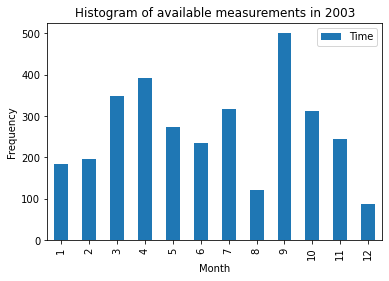

In [8]:
position_df['Time'].groupby(position_df["Time"].dt.month).count().plot(kind="bar", 
                                                               title=(f'Histogram of available measurements in {year}'),
                                                               xlabel='Month',
                                                               ylabel='Frequency', legend=True)

#### Convert to Web-Mercator for Plotting
Convert longitude and latitude to the Web-Mercator projection, which is needed to generate an interactive plot. 

In [9]:
proj_wgs84 = "epsg:4326"
proj_webm = "epsg:3857"

In [10]:
# Reproject positions in the position_df dataframe
position_df['Longitude'], position_df['Latitude'] = reproject(proj_wgs84, 
                                                              proj_webm, 
                                                              position_df['Latitude_WGS84'], # latitude 
                                                              position_df['Longitude_WGS84']) # longitude
position_df

,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
Index_Relative,,,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0,5.137951e+05,8.569851e+06
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1,4.951825e+05,8.568256e+06
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2,4.770374e+05,8.568986e+06
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3,4.583024e+05,8.568143e+06
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4,4.394337e+05,8.569146e+06
...,...,...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204,1.747326e+06,1.148968e+07
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205,1.392128e+06,1.148924e+07
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206,1.447743e+06,1.166426e+07


#### Plot Positions
Plot locations on an interactive plot, color-coded by platform of acquisition. The plot allows you to:
* hoover your mouse on a point to see platform, longitude and latitude 
* pan across the map 
* zoom by selection box
* zoom in and out 
* reset plot to starting view
* toggle off / on positions of specific platforms by clicking on respective names on the legend 

In [11]:
# Plot all locations (in Web Mercator projection)
xlim = (min(position_df['Longitude'])-1, max(position_df['Longitude'])+1)
ylim = (min(position_df['Latitude'])-1, max(position_df['Latitude'])+1)
title = f'All measurement points, Projection: {proj_webm}'
plotInteractive(position_df, title, 'Longitude', 'Latitude', xlim, ylim)

Loading BokehJS ...

Based on the interactive plot above, we can reflect on the distribution of the available data, in order to anticipate the effect of applying filters for optimising the data retrieval.

Some filtering decisions can be made, for example, on the bounding box of interest, the platforms to be selected, and the time range. 

### Filter Positions (based on *position_df*)
This section shows a few examples of data filtering by using the **LATITUDE**, **LONGITUDE** and **TIME** dimensions. First, the data is filtered by bounding box (BBOX). Subsequently, this data is further filtered using a time range.

#### Filter by BBOX
The BBOX boundaries must be entered in geographic coordinates (WGS84).

Format to use: minLong, maxLong, minLat, maxLat (eg: -4, 18, 42, 72) 

In [14]:
bbox_dict = {}

# bbox_dict['BBOX=UserAOI'] = [-4, 18, 42, 72]
# bbox_dict['BBOX=North Sea'] = [-5, 15, 53, 60]
bbox_dict['User_AOI'] = [-4, 7, 57, 62] # Zoom South West, off-Norway

bbox_key = list(bbox_dict.keys())[0]
bbox = bbox_dict[bbox_key]

In [15]:
# Reproject BBOX
bbox_reprj_lat, bbox_reprj_long = reproject(proj_wgs84, 
                                            proj_webm, 
                                            bbox[2:], # latitude first
                                            bbox[:2]) # then longitude
bbox_repj = list(np.array([bbox_reprj_lat, bbox_reprj_long]).flatten())

# Update bbox_dict
bbox_dict[bbox_key] = bbox_repj

In [18]:
# Now remove the ouliers outside bbox
position_df_bbox = position_df[(position_df.loc[:,'Longitude'] >= bbox_repj[0]) & 
                               (position_df.loc[:,'Longitude'] <= bbox_repj[1]) & 
                               (position_df.loc[:,'Latitude'] >= bbox_repj[2]) & 
                               (position_df.loc[:,'Latitude'] <= bbox_repj[3])]

print('Year:', year)
print('BBOX:', bbox_key)

sel_outof_all = f'{len(position_df_bbox)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

display(position_df_bbox)

#print(position_df_bbox.index) # You can use the display(data[var].data[:][position_df_bbox.index]) to select the physical variables values of only those points within specific bbox

title = f'Filtered data: {bbox_key}'
plotInteractive(position_df_bbox, title, 'Longitude', 'Latitude', xlim, ylim, bbox_dict=bbox_dict)

Year: 2003
BBOX: User_AOI
Selected positions (out of available positions): 673 out of 3209.


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
Index_Relative,,,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0,513795.106784,8.569851e+06
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1,495182.478071,8.568256e+06
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2,477037.389182,8.568986e+06
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3,458302.355061,8.568143e+06
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4,439433.688845,8.569146e+06
...,...,...,...,...,...,...,...
296,-2.0248,61.100800,2003-04-26 13:54:05,JH,2555,-225399.711880,8.649005e+06
297,-1.8873,61.068199,2003-04-26 14:40:05,JH,2556,-210093.276588,8.641500e+06
298,-1.5865,61.001301,2003-04-26 15:57:45,JH,2557,-176608.377558,8.626122e+06


Loading BokehJS ...

#### Filter by BBOX, adding Time Range filter

In [22]:
# Define start and end date in the format [day,month,year]
time_start = [1,9,year] 
time_end = [30,11,year] 

time_start = datetime(time_start[2], time_start[1], time_start[0])
time_end = datetime(time_end[2], time_end[1], time_end[0])

time_filter_str = f'{time_start.strftime("%Y%m%d")}-{time_end.strftime("%Y%m%d")}'
print(f'Time Filter: {time_filter_str}')

position_df_bbox_timerange = position_df_bbox.loc[(position_df_bbox['Time']>=time_start) & 
                                                  (position_df_bbox['Time']<=time_end)]
display(position_df_bbox_timerange)

title = f'Filtered data: {bbox_key} and Time={time_filter_str}'
plotInteractive(position_df_bbox_timerange, title, 'Longitude', 'Latitude', xlim, ylim, bbox_dict)

Time Filter: 20030901-20031130


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
Index_Relative,,,,,,,
542,5.3070,61.081501,2003-10-19 10:14:14,AA,542,590772.555475,8.644561e+06
543,5.3070,61.081501,2003-10-19 10:57:30,AA,543,590772.555475,8.644561e+06
544,5.5597,60.870701,2003-10-20 05:01:26,AA,544,618902.974322,8.596194e+06
545,5.3862,60.871799,2003-10-20 09:40:34,AA,545,599589.035875,8.596446e+06
546,5.4713,60.882000,2003-10-20 15:32:41,AA,546,609062.343906,8.598779e+06
...,...,...,...,...,...,...,...
984,1.4820,57.785301,2003-10-03 09:29:57,GT,2073,164975.484612,7.922351e+06
985,0.5797,57.749298,2003-10-03 17:29:19,GT,2074,64531.908048,7.914836e+06
986,0.5003,57.240501,2003-10-03 22:24:21,GT,2075,55693.140150,7.809435e+06


Loading BokehJS ...

#### Print or Export Filtered Positions
Uncomment the rows below if you want to display or export to CSV the filtered dataframe.

In [20]:
# # Print filtered dataframe
# pd.set_option('display.max_rows', None)
# display(position_df_bbox_timerange)

# # Save dataframe to csv
# data_output = os.path.join(os.getcwd(), 'data_output')
# if not os.path.exists(data_output): os.mkdir(data_output)
# csvname = os.path.join(data_output, f'filtered_{pc}_df.csv')
# position_df_bbox_timerange.to_csv(csvname, sep=',', header=True)

#### Zoom in on Filtered Positions
Plot filtered positions with the relavite extent of those positions only.

In [23]:
xlim_small = (min(position_df_bbox_timerange['Longitude'])-1, max(position_df_bbox_timerange['Longitude'])+1)
ylim_small = (min(position_df_bbox_timerange['Latitude'])-1, max(position_df_bbox_timerange['Latitude'])+1)
title = f'Filtered data: {bbox_key} and Time={time_filter_str}'
plotInteractive(position_df_bbox_timerange, title, 'Longitude', 'Latitude', xlim_small, ylim_small)

Loading BokehJS ...

#### Define Filtered Dataframe (*df_toPlot*) to be used for online querying of the filtered positions
Define the filtered dataframe (eg *position_df_bbox*, *position_df_bbox_timerange*), to be named **df_toPlot**, and the dictionary of indices of filtered data (to be named **index_dict**), to use for further filtering.

In [24]:
# Define dataframe to plot based on one of the previously defined filters
df_toPlot = position_df_bbox_timerange # or position_df / position_df_bbox

sel_outof_all = f'{len(df_toPlot)} / {len(position_df)}.'

print(f'- Filters: "BBOX={bbox_key}" and "Time={time_filter_str}"\n- Filtered / All (out of available positions): {sel_outof_all}')

display(df_toPlot)

# Dictionary of indices
index_dict = {}

for pc in df_toPlot['Platform'].unique():
    index_dict[pc] = df_toPlot[df_toPlot['Platform']==pc].index.tolist()

# index_dict

- Filters: "BBOX=User_AOI" and "Time=20030901-20031130"
- Filtered / All (out of available positions): 244 / 3209.


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
Index_Relative,,,,,,,
542,5.3070,61.081501,2003-10-19 10:14:14,AA,542,590772.555475,8.644561e+06
543,5.3070,61.081501,2003-10-19 10:57:30,AA,543,590772.555475,8.644561e+06
544,5.5597,60.870701,2003-10-20 05:01:26,AA,544,618902.974322,8.596194e+06
545,5.3862,60.871799,2003-10-20 09:40:34,AA,545,599589.035875,8.596446e+06
546,5.4713,60.882000,2003-10-20 15:32:41,AA,546,609062.343906,8.598779e+06
...,...,...,...,...,...,...,...
984,1.4820,57.785301,2003-10-03 09:29:57,GT,2073,164975.484612,7.922351e+06
985,0.5797,57.749298,2003-10-03 17:29:19,GT,2074,64531.908048,7.914836e+06
986,0.5003,57.240501,2003-10-03 22:24:21,GT,2075,55693.140150,7.809435e+06


## Data Processing: Load and Plot selected Data (Variables within DEPTH range)

This section enables fetching data of **selected variables** and **within a specified DEPTH range**, to avoid downloading unnecessary data and minimise data volume.

The list of variables need to be specified in the *vars_sel* variable. The four CTD physical variables that are available in this dataset (from OPeNDAP DDS information) are: 
* **PRES**: Sea Water Pressure
* **TEMP**: Sea Water Temperature
* **PSAL**: Sea Water Practical Salinity
* **CNDC**: Sea Water Electrical Conductivity 

The depth range must also be defined. For some limitations of the DAP syntax, at least one range boundary needs to correspond to one of the two extremes. For example, in a data array of 100 elements starting from 0 to 99, the following scenarios are possible:
* select the first 20 elements, corresponding to the values range 0 - 19 --> ```[first:1:intermediate] (eg [0:1:19])``` work
* select the last 20 elements, corresponsing to the values range 80 - 99 --> ```[intermediate:1:last] (eg [80:1:99])``` work
* select the intermediate 60-80 elements, corresponsing to the values range 60 - 79 --> ```[intermediate_1:1:intermediate_2] (eg [80:1:89])``` does NOT work

## Data Extraction
The CTD data is extracted based on the following parameters: Variables, Depth range, and Platform code. 

Afterwards, an additional filtering is applied based on the list of indices that will be extracted from the dictionary of positions (*df_toPlot*). 

### Define Parameters

In [25]:
# Define Variable(s)
vars_main = ['PRES', 'TEMP', 'PSAL', 'CNDC'] 

# Define the selection of variable to use for the analysis
vars_sel = ['TEMP'] #, 'CNDC', 'PSAL']; 
assert all([elem in vars_main for elem in vars_sel])

In [26]:
# Define depths limits
depth1 = 0
depth2 = 50

In [27]:
# Define Platform(s) - Select either one of the two options below  

#================================================
# Option A) Use data from ALL available platforms
pc_sel = df_toPlot['Platform'].unique()

# Option B) Use data from only ONE platform
# pc_sel = ['AA']; assert pc_sel in df_toPlot['Platform'].unique(), 'ERROR: platform not available in given year.'
#================================================

# Create string for output name
if len(pc_sel) == 1: pc_str = pc_sel[0]
else: pc_str = "-".join(pc_sel)
    
# Print selection
print(f'Platform(s) selected: {pc_str}')

Platform(s) selected: AA-GS-GT


### Create **data_dict** dictionary 
Data and their attributes are read iteratively for selected platform(s), and saved into a dictionary *data_dict* which contains:
* the actual data, loaded into an **xarray** for data handling, analysis and visualisation
* the campaign's main attributes: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max.

In [28]:
data_dict = {}
metadata = {}

for pc in pc_sel:
    
    metadata[pc] = {}

    v_min = int(float(position_dict[pc]['data_attr'][6]))
    metadata[pc]['vmin'] = v_min
    metadata[pc]['depth_abs_v1'] = 0 # this is fixed
    metadata[pc]['depth_abs_v2'] = pc_dim_dict[pc]['DEPTH'] # this is fixed

    # ==============================================================================
    """
    Define here the DEPTH range of your selection, in meters. Note that either:
    - 'depth_m_v1' is equal to the lower bound (ie index=0), or 
    - 'depth_m_v2' is equal to the upper bound (ie index=-1)
    """
    metadata[pc]['depth_m_v1'] = 0 # depth1
    metadata[pc]['depth_m_v2'] = depth2 # pc_dim_dict[pc]['DEPTH']
    # ==============================================================================

    # assert metadata[pc]['depth_m_v1'] < metadata[pc]['depth_m_v2'], 'ERROR: the lower bound must be lower than the higher bound' 
    # assert metadata[pc]['depth_m_v1'] == 0 or metadata[pc]['depth_m_v2'] == pc_dim_dict[pc]['DEPTH'], 'ERROR: one of the two values must be equal to one of the lower/upper bounds'

    #     print(f'DEPTH range of interest (meters): {metadata[pc]["depth_m_v1"]} - {metadata[pc]["depth_m_v2"]}')

    # the start and stop values are adjusted based on the vmin value
    if metadata[pc]['vmin'] == 1: 
        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] # the same
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] # the same, so I have the right size. When I shift and add the nan, I get rid of further element on the right
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']# - 1

        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] - 1 # start one element before
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] - 1 # last element is excluded, ie stop one element before. But then I'll have to remoove one element
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1'] - 1 

    else:
        metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1']
        metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2']

        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']

        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1']

    metadata[pc]['depth_newindex4xr_v1'] = 0

    pprint.pprint(metadata[pc])
    print(f'{pc} DEPTH range of interest (adjusted with vmin): {metadata[pc]["depth_newindex_v1"]} - {metadata[pc]["depth_newindex_v2"]}')

    fix_lab = f'58{pc}_CTD_{year}' # platform_codes and year are defined at the beginning of the notebook 

    # Get coordinates (needed for keeping hte correct structure, and for plotting) 
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want

    # Extract TIME and DEPTH dimension for queries 
    time_dims = getQuery(pc, start=0, stop=pc_dim_dict[pc]['TIME'])
    depth_dims = getQuery(pc, start=metadata[pc]['depth_newindex_v1'], stop=metadata[pc]['depth_newindex_v2'])#; print(depth_dims)

    # join TIME and DEPTH for Variables
    var_str_ALL = []
    for v in vars_sel: var_str_ALL = np.append(var_str_ALL, f'{v}{time_dims}{depth_dims}')
    queries_vars = ','.join(var_str_ALL)

    # Build url and url with queries (url_q)
    url = f'{url_info[0]}{fix_lab}.nc{url_info[1]}?{coords_str}' 
    url_q = f'{url},{queries_vars}'; print(f'Platform {pc} URL:', url_q)

    remote_data, data_attr = fetch_data(url_q, year)

    data_dict[pc] = {'data': remote_data, 
                     'data_attr': data_attr}

    print(f'{data_attr}\n')

# display(data_dict)
print(f'Checking the existing campaigns in the dictionary: {list(data_dict.keys())}')

{'depth_abs_v1': 0,
 'depth_abs_v2': 2809,
 'depth_m_v1': 0,
 'depth_m_v2': 50,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 50,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 50,
 'vmin': 0}
AA DEPTH range of interest (adjusted with vmin): 0 - 50
Platform AA URL: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2003.nc?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683],TEMP[0:1:683][0:1:50]
['58AA' 'H\\303\\245kon Mosby' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '0.000'
 '2811.000' '-11.884' '17.833' '53.996' '69.999']

{'depth_abs_v1': 0,
 'depth_abs_v2': 3683,
 'depth_m_v1': 0,
 'depth_m_v2': 50,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 50,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 50,
 'vmin': 1}
GS DEPTH range of interest (adjusted with vmin): 0 - 50
Platform GS URL: http://opendap1.nodc.no/opendap/physics/point/yearly/58GS_CTD_2003.nc?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404],

### Create Overview Dataframe with Platforms' Attributes
An overview dataframe *overview_df* is then generated to show the detailed information about each campaign at sea: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max).

In [29]:
# Create database with the selected campaigns & years
overview_df = pd.DataFrame()
overview_df = getAttributes(overview_df, data_dict)
overview_df

,Platform_code,Platform_name,Year,Data_type,Title,Instrument,Vertical_min,Vertical_max,Lon_min,Lon_max,Lat_min,Lat_max
AA,58AA,H\303\245kon Mosby,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,0.0,2811.0,-11.884,17.833,53.996,69.999
GS,58GS,G.O. Sars,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3688.0,-17.979,22.532,59.280,78.336
GT,58GT,Sarsen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,2962.0,-9.520,35.016,56.667,78.655


In [30]:
# Extract / define the variables to use for the analysis
print('\nPrinting DEPTH range for analyis:')
assert len(np.unique([metadata[k]["depth_m_v1"] for k in metadata.keys()])==1)
assert len(np.unique([metadata[k]["depth_m_v2"] for k in metadata.keys()])==1)

for k in data_dict.keys():
    print(f'{k}; DEPTH filtered: {metadata[k]["depth_m_v1"]}-{metadata[k]["depth_m_v2"]}m; VARS: {list(data_dict[k]["data"].variables)}')


Printing DEPTH range for analyis:
AA; DEPTH filtered: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']
GS; DEPTH filtered: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']
GT; DEPTH filtered: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']


In [31]:
# Generate vmin dictionary (needed to avoid doing the vmin adjustment more than once)
vmin_dict = {}

# select only those platforms where vmin == 1
vmin_pc = overview_df[overview_df['Vertical_min'] == 1.0].index

for i in vmin_pc:
    vmin_dict[i] = {}
    
    for v in vars_sel:
        vmin_dict[i][v] = False

vmin_dict   

{'GS': {'TEMP': False}, 'GT': {'TEMP': False}}

### Filter by DEPTH and selected Indices
Apply the previously defined selection of indices (filtered based on BBOX and Time Range), and add filtering by DEPTH range. 

The output of this operation is a *filtered_xarr_dict* dictionary containing xarray datasets for each platform, containing the variable at the specified DEPTH range

#### Data filtered by DEPTH

In [32]:
filtered_xarr_dict = {}

print(f'Selected range of DEPTH: {depth1} - {depth2}m\n')
for pc in data_dict.keys():

    # Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
    if metadata[pc]['depth_m_v1']==0: align_and_nan = True
    else: align_and_nan = False

    for v in vars_sel: 
        check_alignment(data_dict, pc, v, align_and_nan, vmin_dict)

    filtered_xarr_dict[pc] = filter_xarr_DEPTH(df_toPlot, 
                                               data_dict,
                                               platform=pc,
                                               depth_range=[depth1, depth2])
    display(filtered_xarr_dict[pc])

Selected range of DEPTH: 0 - 50m

Platform: AA; Vertical min: 0.0; Var: TEMP


<xarray.Dataset>
Dimensions:    (TIME: 61, LATITUDE: 61, LONGITUDE: 61, DEPTH: 51)
Coordinates:
  * TIME       (TIME) float64 1.965e+04 1.965e+04 ... 1.969e+04 1.969e+04
  * LATITUDE   (LATITUDE) float32 61.08 61.08 60.87 60.87 ... 60.82 60.87 60.88
  * LONGITUDE  (LONGITUDE) float32 5.307 5.307 5.56 5.386 ... 5.341 5.365 5.466
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 9.35 9.289 9.311 ... 10.41 10.35 10.38
Attributes: (12/152)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_DM._FillValue:              
    CNDC_DM.conventions:            Copernicus Marine In Situ reference table 1
    CNDC_DM.flag_values:            R, A, D
    CNDC_DM.flag_meanings:          real-time adjusted-in-real-time delayed-mode
    CNDC_DM.long_name:              Electrical conductivity method of data pr...
    CNDC_DM.string_length:          2810

Platform: GS; Vertical min: 1.0; Var: TEMP --> aligning and add nan


<xarray.Dataset>
Dimensions:    (TIME: 129, LATITUDE: 129, LONGITUDE: 129, DEPTH: 51)
Coordinates:
  * TIME       (TIME) float64 1.964e+04 1.964e+04 ... 1.967e+04 1.967e+04
  * LATITUDE   (LATITUDE) float32 61.21 61.12 61.04 60.96 ... 59.29 59.28 60.45
  * LONGITUDE  (LONGITUDE) float32 -3.686 -3.276 -2.898 ... 4.933 5.035 3.28
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 nan 10.36 10.36 10.36 ... 10.35 10.39 10.46
Attributes: (12/128)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

Platform: GT; Vertical min: 1.0; Var: TEMP --> aligning and add nan


<xarray.Dataset>
Dimensions:    (TIME: 54, LATITUDE: 54, LONGITUDE: 54, DEPTH: 51)
Coordinates:
  * TIME       (TIME) float64 1.962e+04 1.962e+04 ... 1.963e+04 1.964e+04
  * LATITUDE   (LATITUDE) float32 60.67 61.2 61.65 60.21 ... 57.24 57.13 57.69
  * LONGITUDE  (LONGITUDE) float32 -0.3033 -0.2672 -0.347 ... -0.5513 -0.5153
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 nan 13.39 13.39 13.39 ... 12.9 12.9 12.9
Attributes: (12/128)
    _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

### Aggregation of Available Platforms
Two xarray datasets can be merged if they have the same structure, i.e. dimensions. First check the dimensions of DEPTH are the same.

In [33]:
# Dictionary of variables for each platform
data_var_dict = {}
depth_arr = []

for pc in data_dict.keys():
    
    data_var_dict[pc] = {}
    data = filtered_xarr_dict[pc]
    
    depth_dim_pc = data.dims["DEPTH"]
    depth_arr.append(depth_dim_pc)
    
    print(f'PC {pc}\tFiltered Dims: TIME={data.dims["TIME"]}, DEPTH={data.dims["DEPTH"]}')
    
    for var in vars_sel:
        data_var_dict[pc][var] = filtered_xarr_dict[pc][var]
        
assert all(x==depth_arr[0] for x in depth_arr), 'ERROR, the DEPTH dimensions must be equal.'
# display(data_var_dict)

PC AA	Filtered Dims: TIME=61, DEPTH=51
PC GS	Filtered Dims: TIME=129, DEPTH=51
PC GT	Filtered Dims: TIME=54, DEPTH=51


Now aggregate and plot each variable: on the y-axis is shown the TIME of the measurement (in float format, which needs to be converted to datetime format), and on the x-axis is the DEPTH of the measurement.

<xarray.Dataset>
Dimensions:  (TIME: 244, DEPTH: 51)
Coordinates:
  * TIME     (TIME) float64 1.962e+04 1.962e+04 ... 1.969e+04 1.969e+04
Dimensions without coordinates: DEPTH
Data variables:
    TEMP     (TIME, DEPTH) float64 nan 13.39 13.39 13.39 ... 10.41 10.35 10.38
Attributes:
    standard_name:        sea_water_temperature
    long_name:            Sea temperature
    units:                degrees_C
    valid_min:            -2500
    valid_max:            40000
    ancillary_variables:  TEMP_QC TEMP_DM
    data_mode:            M

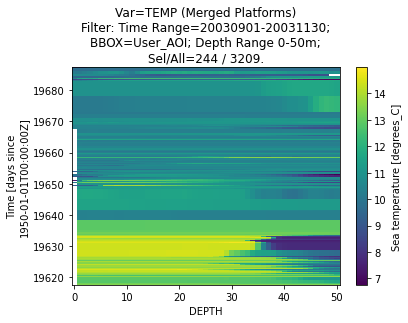

In [34]:
# Combine arrays across platforms, for each variable
merged_arr = {}

for var in vars_sel:
    
    merged_arr[var] = xr.merge([data_var_dict[pc][var] for pc in data_dict.keys()])  
        
    title = f'Var={var} (Merged Platforms)\nFilter: Time Range={time_filter_str};\nBBOX={bbox_key}; Depth Range {depth1}-{depth2}m;\nSel/All={sel_outof_all}'

    plotVar_MergedPlatforms(merged_arr[var], var, title=title)
    display(merged_arr[var])

To Recap:
* ```data_dict[pc]['data']```: contains the xarray extracted from the url (eg from **0** to **depth2**, for ALL locations)
* ```filtered_xarr```: contains the xarray filtered from ```data_dict[pc]['data']``` (ie from **depth1** to **depth2**, for filtered locations (BBOX and time_range))

### Create Dataframe of Filtered XARRAY and Export to CSV
This step is implemented to generate a CSV-structured dataframe, to then export to a CSV file, which is the input expected by the RGeostats module.

In [35]:
# Create dataframe with filtered data and columns ['LATITUDE', 'LONGITUDE', 'TIME', 'TEMP', 'DEPTH']
filtered2csv_multiDepths = pd.DataFrame() 

for pc in data_dict.keys():

    for d in range(depth1, depth2+1):

        # Create temporary dataframe
        temp = pd.DataFrame()

        data_depth_sel = data_dict[pc]['data'].isel(TIME=index_dict[pc],
                                                    LATITUDE=index_dict[pc],
                                                    LONGITUDE=index_dict[pc],
                                                    DEPTH=slice(d, d+1))

        for col in ['LONGITUDE', 'LATITUDE', 'TIME']:
            temp[col.title()] = data_depth_sel[col].data.astype(float) 

        if 'TEMP' in vars_sel: temp['Temperature'] = data_depth_sel['TEMP'].data.astype(float) 
        if 'CNDC' in vars_sel: temp['Conductivity'] = data_depth_sel['CNDC'].data.astype(float) 
        if 'PSAL' in vars_sel: temp['Salinity'] = data_depth_sel['PSAL'].data.astype(float) 

        temp['Depth'] = d 
        temp['Vessel_name'] = pc 

        filtered2csv_multiDepths = filtered2csv_multiDepths.append(temp, ignore_index=True)
    
# Rename index column with 'rank'
filtered2csv_multiDepths = filtered2csv_multiDepths.rename_axis("rank")

display(filtered2csv_multiDepths)

,Longitude,Latitude,Time,Temperature,Depth,Vessel_name
rank,,,,,,
0,5.3070,61.081501,19649.426551,9.350,0,AA
1,5.3070,61.081501,19649.456597,9.282,0,AA
2,5.5597,60.870701,19650.209329,10.699,0,AA
3,5.3862,60.871799,19650.403171,10.088,0,AA
4,5.4713,60.882000,19650.647697,10.698,0,AA
...,...,...,...,...,...,...
12439,1.4820,57.785301,19633.395799,9.676,50,GT
12440,0.5797,57.749298,19633.728692,13.053,50,GT
12441,0.5003,57.240501,19633.933576,13.135,50,GT


#### Assign *Profil_id* to the unique positions

In [36]:
# find pair of unique coordinates 
unique_pos = filtered2csv_multiDepths.groupby(['Longitude','Latitude']).size().reset_index().rename(columns={0:'count'})

prof_id = 1
for long, lat in zip(unique_pos['Longitude'], unique_pos['Latitude']):
    
    # Define condition
    cond = (filtered2csv_multiDepths['Longitude'] == long) & (filtered2csv_multiDepths['Latitude'] == lat)
#     display(filtered2csv_multiDepths.loc[cond])
    
    # Assign unique Profil_id 
    filtered2csv_multiDepths.loc[cond,'Profil_id'] = prof_id
    prof_id += 1

# Convert to integer
filtered2csv_multiDepths = filtered2csv_multiDepths.astype({'Profil_id': int})
display(filtered2csv_multiDepths)

,Longitude,Latitude,Time,Temperature,Depth,Vessel_name,Profil_id
rank,,,,,,,
0,5.3070,61.081501,19649.426551,9.350,0,AA,200
1,5.3070,61.081501,19649.456597,9.282,0,AA,200
2,5.5597,60.870701,19650.209329,10.699,0,AA,215
3,5.3862,60.871799,19650.403171,10.088,0,AA,206
4,5.4713,60.882000,19650.647697,10.698,0,AA,211
...,...,...,...,...,...,...,...
12439,1.4820,57.785301,19633.395799,9.676,50,GT,71
12440,0.5797,57.749298,19633.728692,13.053,50,GT,47
12441,0.5003,57.240501,19633.933576,13.135,50,GT,41


#### Export to CSV

In [37]:
# Save dataframe to csv
data_output = os.path.join(os.getcwd(), 'data_output')
if not os.path.exists(data_output): os.mkdir(data_output)
    
csvname = os.path.join(data_output, 
                       f'Scientist_pc={pc_str}_BBOX={bbox_key}_MMYYYY={time_filter_str}_d={depth1}-{depth2}m_var={"_".join(vars_sel)}.csv')

filtered2csv_multiDepths.to_csv(csvname, sep=',', header=True)
print('Output filename:', csvname)

Output filename: /workspace/INTAROS/iaos-showcase-app-Barents-Sea-CTD/data_output/Scientist_pc=AA-GS-GT_BBOX=User_AOI_MMYYYY=20030901-20031130_d=0-50m_var=TEMP.csv


#### Plot Histogram of measurements of filtered data

<AxesSubplot:xlabel='Month & Day', ylabel='Count'>

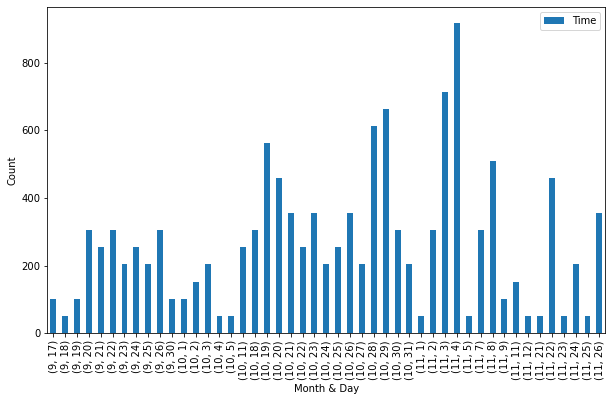

In [38]:
# Create a copy (I need to keep the original as it is, because Time needs to be a floating number)
filtered2csv_multiDepths_time = filtered2csv_multiDepths.copy()

# Convert Time from float to datetime
filtered2csv_multiDepths_time['Time'] = [start_date + timedelta(t) for t in filtered2csv_multiDepths_time.loc[:,'Time']]

# Plot Histogram
filtered2csv_multiDepths_time["Time"].groupby([filtered2csv_multiDepths_time["Time"].dt.month,
                                               filtered2csv_multiDepths_time["Time"].dt.day]).count().plot(figsize=(10,6),
                                                                                                           kind="bar", 
                                                                                                           legend=True, 
                                                                                                           xlabel='Month & Day', 
                                                                                                           ylabel='Count')

# Geostatistical Analysis with RIntaros/RGeostats

The aim is to generate an estimation map and the corresponding error map of the selected variables (e.g. temperature, salinity) in the given region of interest (e.g. Barents sea) from spatio-temporal data measured along vertical CTD profiles.

This study is performed using RIntaros and RGeostats packages. Both packages are software developed in R programming language. The official website for downloading and learning how to use them is the following: http://cg.ensmp.fr/rgeostats.

In this Notebook, the variable **Temperature** is shown as an example.

There are a number of preparatory steps to implement, which allow to fine-tuning the parameters for modelling the interpolation of the variable.

This builds on the RGeostats workshop, held in Bremen in 2019. The material is available on https://github.com/ec-intaros/RGeostats-workshop. 

## Set-up

### Install R Kernel
R code can be executed in this Python environment by using magic cells ```%%R``` and rpy2 module.

In [42]:
%load_ext rpy2.ipython

### Install RIntaros and RGeostats

In order to install **RGeostats** and **RIntaros** packages, look at the latest version on the following website http://cg.ensmp.fr/rgeos/DOWNLOAD/ for your operating system.

Then, adapt the following code with the appropriate URL (version and operating system).

If you have some doubts oninstallation procedure, you may refer to the official website: http://cg.ensmp.fr/rgeostats.

The following instructions are in comment because those must be executed only once.

In [44]:
%%R
# For Linux
install.packages("http://cg.ensmp.fr/rgeos/DOWNLOAD/RGeostats_13.0.1_linux64.tar.gz", repos=NULL)
install.packages("http://cg.ensmp.fr/rgeos/DOWNLOAD/RIntaros_2.2_linux64.tar.gz", repos=NULL)

# Fo windows
#install.packages("http://cg.ensmp.fr/rgeos/DOWNLOAD/RGeostats_13.0.1.zip", repos=NULL)
#install.packages("http://cg.ensmp.fr/rgeos/DOWNLOAD/RIntaros_2.2.zip", repos=NULL)

R[write to console]: trying URL 'http://cg.ensmp.fr/rgeos/DOWNLOAD/RGeostats_13.0.1_linux64.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 17774531 bytes (17.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

### Import variables from Python

'19500101'

In [64]:
import rpy2.robjects as robjects

# BBOX (note it's stored as an array of format: [minLong, maxLong, minLat, maxLat, eg [30, 60, 50, 80]]
robjects.globalenv['bbox_key'] = bbox_key
robjects.globalenv['long_min'] = bbox[0]
robjects.globalenv['long_max'] = bbox[1]
robjects.globalenv['lat_min'] = bbox[2]
robjects.globalenv['lat_max'] = bbox[3]

# Time Range and Start Date
robjects.globalenv['time_filter_str'] = time_filter_str
robjects.globalenv['year'] = year
robjects.globalenv['start_date_str'] = start_date.strftime("%Y-%m-%d")

# Depth Range
robjects.globalenv['depth1'] = depth1
robjects.globalenv['depth2'] = depth2

# Directory and CSV Name
robjects.globalenv['data_output'] = data_output 
robjects.globalenv['csvname'] = csvname

# Variables
robjects.globalenv['vars'] = '_'.join(vars_sel) 

In [65]:
%%R
# Check Variables
cat('Printing variables imported from Python script:\n')
cat('bbox_key:', bbox_key, '\n')
long_lim   = c(long_min, long_max)
lat_lim    = c(lat_min, lat_max)
cat('long_lim:', long_lim, '\n')
cat('lat_lim:', lat_lim, '\n')
cat('time_filter_str:', time_filter_str, '\n')
cat('year:', year, '\n')
cat('start_date:', start_date_str, '\n')
cat('depth1:', depth1, '\n')
cat('depth2:', depth2, '\n')
cat('data_output:', data_output, '\n')
cat('csvname:', csvname, '\n')
cat('vars:', vars, '\n')

Printing variables imported from Python script:
bbox_key: User_AOI 
long_lim: -4 7 
lat_lim: 57 62 
time_filter_str: 20030901-20031130 
year: 2003 
start_date: 1950-01-01 
depth1: 0 
depth2: 50 
data_output: /workspace/INTAROS/iaos-showcase-app-Barents-Sea-CTD/data_output 
csvname: /workspace/INTAROS/iaos-showcase-app-Barents-Sea-CTD/data_output/Scientist_pc=AA-GS-GT_BBOX=User_AOI_MMYYYY=20030901-20031130_d=0-50m_var=TEMP.csv 
vars: TEMP 


### Load the packages

The next cell loads the packages maps, mapdata and **RIntaros** (which automatically loads RGeostats).

In [66]:
%%R 
# Uncomment this if you want to see the "Welcome message" at package startup
# library(maps)
# library(mapdata)
# library(RIntaros)

suppressPackageStartupMessages(library(maps))
suppressPackageStartupMessages(library(mapdata))
suppressPackageStartupMessages(library(RIntaros))

### Configure the RIntaros Environmnet
We first register global variables and global RIntaros graphical environment (geographical bounds).

In [70]:
%%R 
# Setup RIntaros/RGeostats graphical environment
dir.name   = getwd()
data.name  = basename(data_output)
file.name  = basename(csvname)
intaros.save.environ(long_lim = long_lim, lat_lim = lat_lim,
                     flag_file = FALSE)
# Define reference date (from which Time variable is calculated)
ref.date = start_date_str
setRefDate(ref.date)
# Configure aspect ratio to 1 for all plots
constant.define("asp",1)
# Variable of interest
# Must be the exact name of the variable in the database below)
var = "Temperature"

## Loading Data in RGeostats Database
Loading data from the **CSV** file containing filtered positions previously created (taking the header line into account). Then we create the RGeostats Db. Finally we show the contents of the newly created Db (named **db0**).

In [71]:
%%R 
db0 = imr_read_csv(file.path(dir.name,data.name,file.name))
print(db0) # Same as db.print(db0)
cat("\nNumber of unique profiles:", length(unique(db0$Profil_id)), "\n")


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of fields             = 8
Maximum Number of attributes = 8
Total number of samples      = 12444

Variables
---------
Field = 1 - Name = rank - Locator = NA
Field = 2 - Name = Longitude - Locator = x1
Field = 3 - Name = Latitude - Locator = x2
Field = 4 - Name = Time - Locator = NA
Field = 5 - Name = Temperature - Locator = NA
Field = 6 - Name = Depth - Locator = NA
Field = 7 - Name = Vessel_name - Locator = NA
Field = 8 - Name = Profil_id - Locator = NA

Number of unique profiles: 242 


## Dataset Global Statistics

Generate global statistics of the dataset. As you can see, there is some non available temperature values ('Number' column).

In [72]:
%%R
# Set the locator of the variable of interest in the database.
db0 = db.locate(db0, var, "z")

# Let us get some statistics on the information available
cat(build_title("The dataset period is:", time2date(get_db_limits_time(db0))))
cat('\n\n')
db.stat.print(db = db0, funs = c("num","mini","maxi","mean"),
              names = c("Longitude","Latitude","Depth","Temperature"))

The dataset period is: (2003-09-17 => 2003-11-26)

               Number   Minimum   Maximum      Mean
Longitude       12444    -3.686     6.870     2.857
Latitude        12444    57.132    61.751    59.865
Depth           12444     0.000    50.000    25.000
Temperature     12176     6.755    14.989    11.158



## Studying Variable **Temperature**


### Display Measurement Locations 

We display all samples focusing on the Temperature variable in a 2D aerial view, reporting the country borders. For comparison, we define a common color scale, established on the global minimum and maximum Temperature values (**var.scale0**). Measurements located on a same profile are masked by the deepest value.


Parameters for Projection
-------------------------
Projection is switched ON
Use 'projec.define' to modify previous values


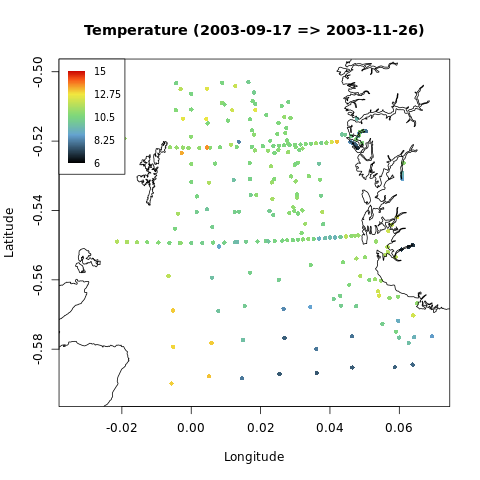

In [81]:
%%R
# Global plot
projec.define(projection="stereographic")
# Deactivate stereographic projection 
# projec.toggle(0)

colors.temp = rg.colors(rank=1)
scale0      = get_db_limits_var(db0,var)
var.scale0  = c(floor(scale0[1]), ceiling(scale0[2]))
display_var(dbin = db0, var = var, var_scale = var.scale0, colors = colors.temp,
            title = build_title_db_time(db0,var), pos.legend = 5)

Take care on the figure above of the size of the field which have a longitude extent twice the latitude extent (in degrees). This field size will be of prime importance when tuning the variogram paramters.

### Display data for a given time interval and a given depth

Here, for example, we can display data for each month of the input filtered time interval and a given depth. This provides you with a simple understanding of the trends for the filtered data sample.

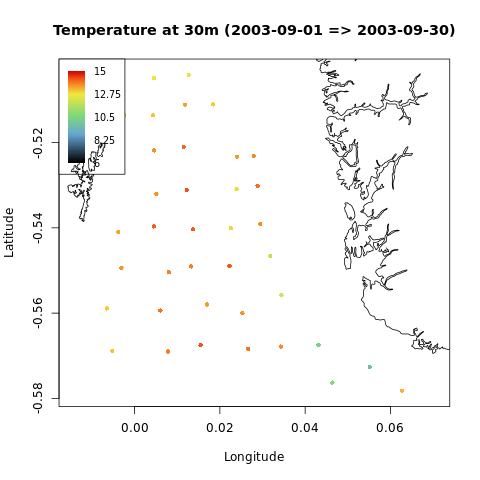

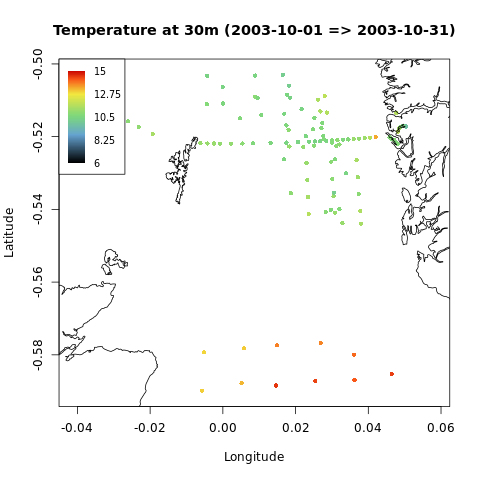

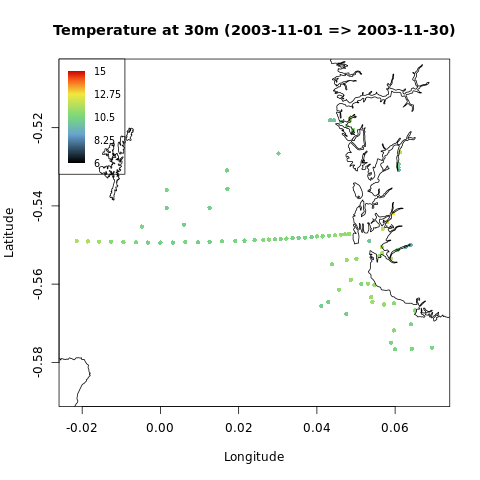

In [78]:
%%R
# Select samples at specific depth and set the color scale
depth = 30 # Required depth to be displayed
depth_lim=c(depth,depth)
db1 = apply_sel(db0, depth_lim=depth_lim)

# Loop on the months to be displayed
months = sort(unique(time2month(db0$Time)))
for (imonth in months)
{
  date_lim  = create_limits_date(year, month=imonth)
  db        = apply_sel(db1,date_lim=date_lim)
  title     = build_title(paste0(var, " at ", depth, "m"), date_lim)
  display_var(dbin = db, var = var,
              var_scale = var.scale0,
              colors = colors.temp,
              title = title, pos.legend = 5)
}

### Block Average

The next display considers the variable values **averaged** over the cells of a coarse grid (mesh of 1 degree). This provides you with a simple understanding of the trends for the filtered data sample. Two plots are produced:
* one showing average of depth of the entire vertical profile (e.g. 0-50m)
* one showing the actual value at specific depth

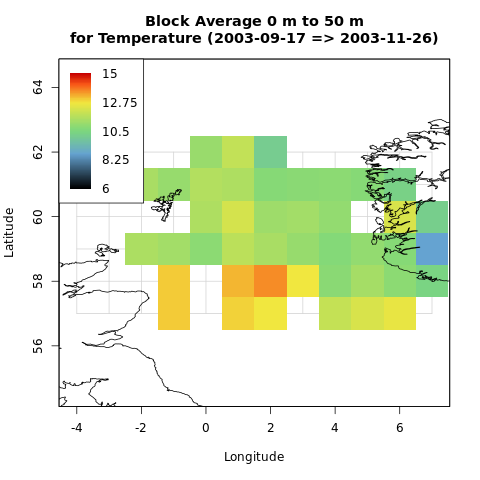

In [82]:
%%R
# Deactivate stereographic projection 
projec.toggle(0)
# Size of the block (1°)
mesh = 1
sub = paste("Block Average",depth1, "m to", depth2, "m\nfor", var)
dbg = stats_grid(db0, var, fun = "mean", mesh = mesh)
display_stats(dbg, var, var_scale = var.scale0, colors = colors.temp,
              title = build_title_db_time(db0,sub), pos.legend = 5)

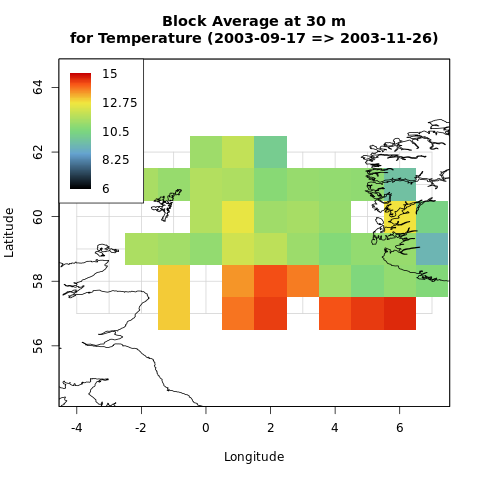

In [83]:
%%R
# Select samples at specific depth
depth = 30 # Required depth to be displayed
depth_lim=c(depth,depth)
db1 = apply_sel(db0, depth_lim=depth_lim)
# Size of the block (1°)
mesh = 1
sub = paste("Block Average at",depth, "m\nfor", var)
dbg = stats_grid(db1, var, fun = "mean", mesh = mesh)
display_stats(dbg, var, var_scale = var.scale0, colors = colors.temp,
              title = build_title_db_time(db0,sub), pos.legend = 5)

### Histogram of Measurement Depths

We can also aggregate (average) the values of all samples vertically in order to reduce the amount of data, in case performance issues with the following steps. This will allow to estimate the map for a fixed target depth while taking into account the neighborhing depth.

The vertical discretization step is automatically calculated according the input depth range and required number of steps **ndepth**.
Then, we can double-check this regularization step by plotting the histogram of the initial depths and the histogram of the regularized depths.

This function requires 0 variables (locator 'Z'). The 'Db' contains 3 variables


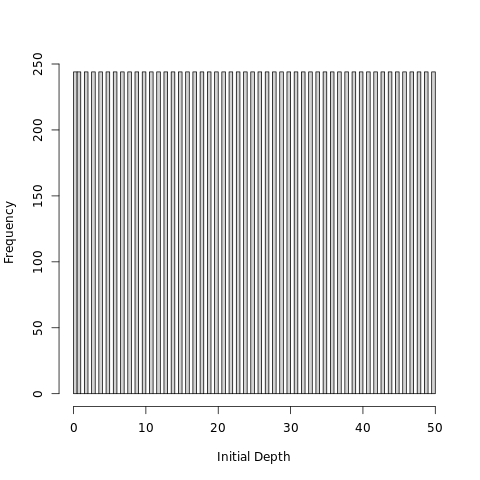

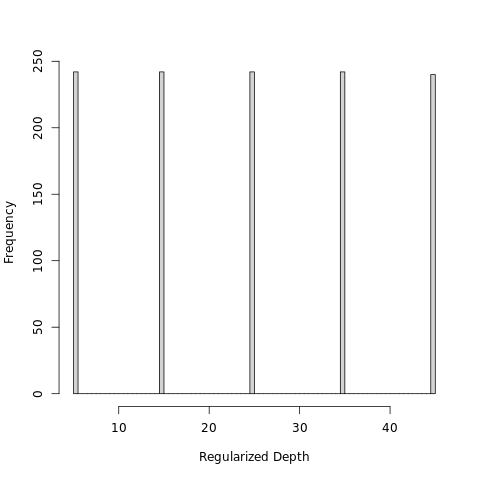

In [84]:
%%R
# Aggregate data along Depth axis
# dbin:       input data grid
# depth0:     origin of depth values
# ddepth:     step along depth
# ndepth:     number of depth steps
ndepth = 5 # Split depth2-depth1 in 5 intervals
ddepth = floor((depth2 - depth1) / ndepth)
dbreg  = aggregate_depth(dbin = db0, depth0 = depth1, ddepth = ddepth, ndepth = ndepth, flag.center = TRUE)

# Histogram of depths (ignore the message)
hist(db0[,"Depth"],breaks=100,xlab="Initial Depth",main="")
hist(dbreg[,"Depth"],breaks=100,xlab="Regularized Depth",main="")

### Statistics per Depth
Considering the filtered data, we evaluate the mean and the variance of the variable of interest per depth level (every 1m). This provides you with a simple understanding of vertical variation for the filtered data sample.

In [85]:
%%R
# Override aggregate_depth function from RIntaros
# to take into account NA values for calculating statistics
average_depth_withNA <- function(dbin, var, depth0, ndepth, ddepth)
{
  depths = numeric(ndepth)
  count  = numeric(ndepth)
  means  = numeric(ndepth)
  vars   = numeric(ndepth)

  for (i in 1:ndepth)
  {
    dbin = remove_sel(dbin)
    depths[i] = ddepth * (i - 0.5)
    depth_lim = c(depths[i] - ddepth/2, depths[i] + ddepth/2)
    dbin = apply_sel(dbin, depth_lim = depth_lim)
   
    # Calculate the mean and variance
    tab      = db.extract(dbin,var)
    count[i] = length(tab)
    means[i] = mean(na.omit(tab))
    vars[i]  = var(na.omit(tab))
  }
  res = list(count=count, means=means, vars=vars, depths=depths)
  res
}

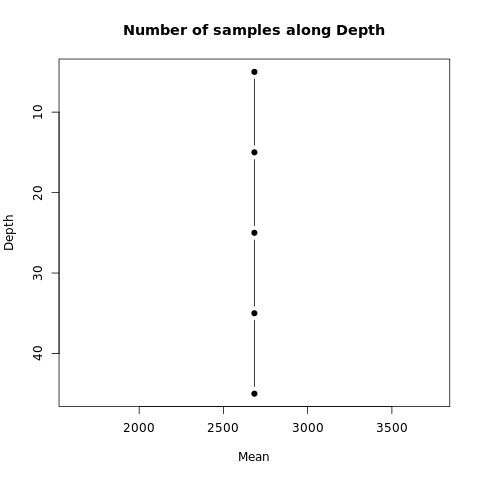

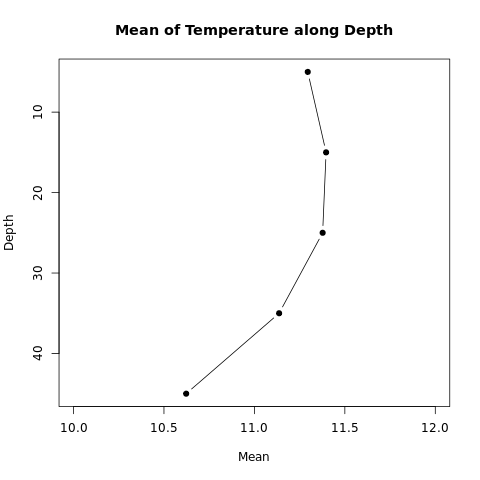

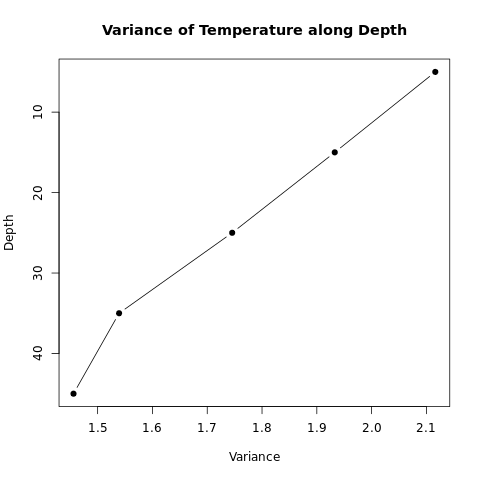

In [86]:
%%R
# Average Temperature by depth
res = average_depth_withNA(db0, var, depth0 = depth1, ndepth = ndepth, ddepth = ddepth)

# Display statistics
plot(res$count,res$depths,type="b",main=paste0("Number of samples along Depth"), pch=19,
     xlab="Mean", ylab="Depth", ylim=rev(range(res$depths)))
plot(res$means,res$depths,type="b",main=paste0("Mean of ",var, " along Depth"), pch=19,
     xlab="Mean", ylab="Depth", ylim=rev(range(res$depths)), xlim=c(10,12))
plot(res$vars,res$depths,type="b",main=paste0("Variance of ",var, " along Depth"), pch=19,
     xlab="Variance", ylab="Depth", ylim=rev(range(res$depths)))

## Variogram Calculation and 2-D Estimation

### Horizontal Omnidirectional Variogram

Calculate the horizontal 2-D omnidiretional variogram for the given time interval at a given depth (future estimation depth) from the aggregated data set (regularized vertically by bench of **ddepth** meter thick).
Display number of pairs used for each variogram's point and display the global variance (dashed line).

In [113]:
%%R
# Here are the depths of the regularized database
cat("Depths (m) from regularized database:", unique(dbreg$Depth), '\n')

Depths (m) from regularized database: 5 15 25 35 45 


In [121]:
%%R
# Define the fixed depth where we want to calculate
# the estimated map of the variable of interest.
# It must be one of the regularized depths displayed above.
depth = 25 # meters
stopifnot('Depth must be within the available regularized depth values above'=depth %in% unique(dbreg$Depth))

To find appropriate variogram parameters, please refer to the RGeostats -Workshop done in Bremen (2019): https://github.com/ec-intaros/RGeostats-workshop (Variography section of imr_case_study)

242  samples have been used for the calculation.

Variogram characteristics
Number of variable(s)       = 1
Number of direction(s)      = 1
Space dimension             = 3
Variance-Covariance Matrix     1.846

Direction #1
------------
Number of lags              = 20
Grid Direction coefficients =          0         0         0

For variable 1
      Rank    Npairs  Distance     Value
         0    63.000     0.063     0.926
         1   360.000     0.213     1.065
         2   515.000     0.407     1.258
         3   667.000     0.603     1.644
         4   751.000     0.801     1.465
         5   956.000     1.004     1.596
         6   963.000     1.200     1.572
         7  1160.000     1.409     1.650
         8  1327.000     1.599     1.513
         9  1246.000     1.801     1.724
        10  1447.000     1.999     1.727
        11  1421.000     2.198     1.857
        12  1373.000     2.398     1.770
        13  1394.000     2.596     1.857
        14  1199.000     2.799     1.91

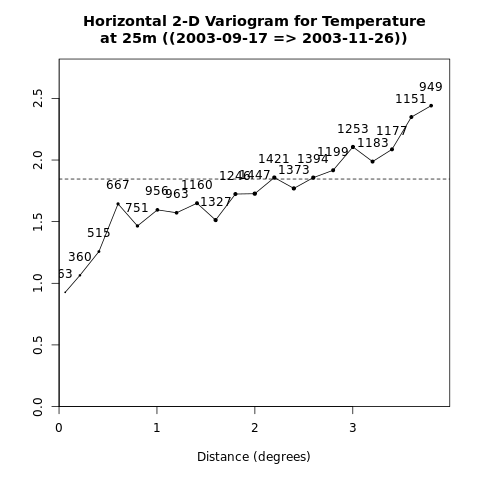

In [122]:
%%R
# Select the data available at this depth only
depth_lim = c(depth,depth)
# Calculate the variogram at the future estimation depth
dbr       = apply_sel(dbreg, depth_lim = depth_lim, compress = FALSE)
dbr       = db.locate(dbr, var, "z")
cat(dbr$nactive, " samples have been used for the calculation.\n")

# Variogram parameters: must be adapted according
# the bounding box area (vario_lag x vario_nlag << maximum field size)
vario_lag  = 0.2 # (distance step 0.2 degree)
vario_nlag = 20  # (number of variogram steps)

# Calculate the experimental variogram
vario = prepar_vario(dbr, dirvect = NA, verbose = 1,
                     vario_lag = vario_lag, vario_nlag = vario_nlag, draw.vario = TRUE,
                     lwd = 1, varline = TRUE, npairdw = TRUE, npairpt = TRUE,
                     xlab = "Distance (degrees)",
                     title = paste0('Horizontal 2-D Variogram for ', var, '\nat ', depth, 'm (', build_title_db_time(dbreg), ')'))

### 2-D Estimation of the variable of interest

We interpolate the variable of interest for the selected time interval, at the given depth. This interpolation starts from the aggregated data. The output grid is automatically calculated (data envelop). The output grid mesh is set to 0.1 degree.

Number of active samples= 242 

Variogram characteristics
Number of variable(s)       = 1
Number of direction(s)      = 1
Space dimension             = 2
Variance-Covariance Matrix     1.846

Direction #1
------------
Number of lags              = 20
Grid Direction coefficients =          0         0

For variable 1
      Rank    Npairs  Distance     Value
         0    63.000     0.063     0.926
         1   360.000     0.213     1.065
         2   515.000     0.407     1.258
         3   667.000     0.603     1.644
         4   751.000     0.801     1.465
         5   956.000     1.004     1.596
         6   963.000     1.200     1.572
         7  1160.000     1.409     1.650
         8  1327.000     1.599     1.513
         9  1246.000     1.801     1.724
        10  1447.000     1.999     1.727
        11  1421.000     2.198     1.857
        12  1373.000     2.398     1.770
        13  1394.000     2.596     1.857
        14  1199.000     2.799     1.917
        15  1253.000     3

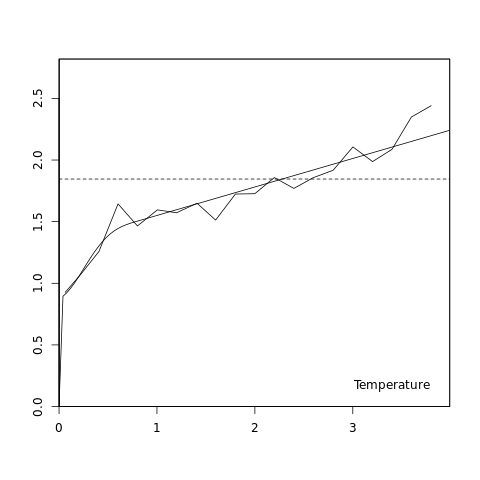

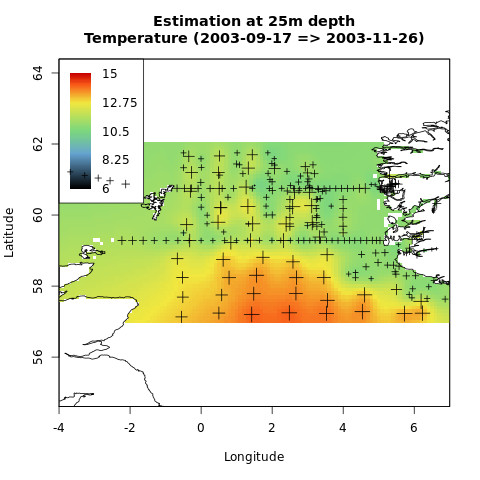

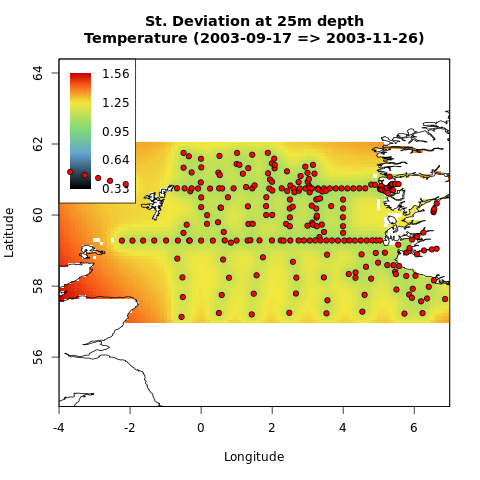

In [123]:
%%R 
# Select the data available at this depth only
depth_lim = c(depth,depth)
# Calculate the variogram at the future estimation depth
dbr       = apply_sel(dbreg, depth_lim = depth_lim, compress = FALSE)
dbr       = db.locate(dbr,var,"z")

# Variogram parameters
vario_lag  = vario_lag # 0.2
vario_nlag = vario_nlag # 20

# Output resolution
omesh = 0.1 # (0.1 degree)

# Perform the interpolation (includes Variogram calculation and Model fitting)
dbg = interpolate_2D(dbr, var, mesh = omesh, moving = FALSE, 
                     vario_lag = vario_lag, vario_nlag = vario_nlag,
                     struct = c("Spherical","Cubic","Linear"), 
                     dirvect = NA, draw.model = TRUE, verbose = 1)

# Display the results
display_result(dbr, dbg, var = var, var_scale = var.scale0, depth = depth, flag.estim = TRUE, 
               colors = colors.temp, pos.legend=5)
display_result(dbr, dbg, var = var, depth = depth, flag.estim = FALSE, 
               colors = colors.temp, pos.legend=5)

## Perspectives

- Take into account projections for estimation
- Improve the data explanatory analysis of CTDs (for example, vertical variations that can be used with a functional kriging)
- Introduce the polynomial drifts to handle temperatures at high latitudes
- Use Salinity as a co-regionalized variable
- Make a global unique 4-D model (spatio-temporal) which will take into account anisotropies and non stationarities.
- Take into account local anisotropies due to the currents for example
- Add SPDEs technique to kriging implementation in order to improve the efficiency
